<a target="_blank" href="https://colab.research.google.com/github/da-python/new-modul-python/blob/main/Lesson3/hometask/SyntheticRubber.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [2]:
!pip install yfinance

     -------------------------------------- 59.7/59.7 kB 526.2 kB/s eta 0:00:00
     -------------------------------------- 502.3/502.3 kB 2.9 MB/s eta 0:00:00
     -------------------------------------- 112.2/112.2 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successfully uninstalled pytz-2022.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.20 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.20 requires nbformat==5.4.0, but you have nbformat 5.5.0 which is incompatible.


In [184]:
import os
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt 
import xlsxwriter
import requests
import numpy as np
import json
from pylab import rcParams

In [185]:
crude_oil_ticker = "CL=F"
euro_usd = 'EURUSD=X'
usd_rub = 'RUB=X'
crude_oil = yf.Ticker(crude_oil_ticker)
Oil_price_full = yf.download(crude_oil_ticker)
euro_price_full = yf.download(euro_usd)
rub_price_full = yf.download(usd_rub)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Задание 1.

* Вы - менеджер по продажам в нефтехимической компании. Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании. Ваша компания запускает новый продукт - "Синтетический каучук" (СК), который по своим свойствам похож на тот, что уже есть на рынке. Ваши клиенты предпочитают формульный подход к ценообразованию. Вам нужно предложить клиентам формулу расчета цены на СК. В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.


* СК производиться из нефти. Один из известных способов производства предполагает, что из 10 баррелей нефти сделают одну тонну СК, а затраты на производство в районе 400 евро.

In [186]:

# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

# Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

# * Справочная информация по клиентам(объемы, локации, комментарии) 
with open('customers.txt') as f:
    data = f.read()
    customers = json.loads(data)
# Скидки
discounts = {'99': 0.01, # до 100 тонн 1%
             '299': 0.05, #  до 300 тонн 5%
             '300': 0.1}   # больше 300 тонн 10%


In [187]:
#open("customers.txt", "w").write(json.dumps(customers))

### Что нужно сделать?

1. Определить базовую формулу цены на заводе. То есть как бы выглядела цена на исторических данных. 
* Важно, чтобы цена покрывала расходы на производство и при этом была в рынке, то есть на уровне натурального каучука или с небольшим дисконтом, котировки на который можно взять с сайта http://www3.lgm.gov.my/mre/MonthlyPrices.aspx (в центах за килограм). Можно перевести в доллары за тонну.
2. Отобразить на графике.
3. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
4. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
- Создать директорию «для клиентов» и в ней сложить  файлы с расчетами.
- Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf)  с именем клиента… 



In [188]:
Oil_price = pd.DataFrame(Oil_price_full, columns = ['Close'])
euro_price = pd.DataFrame(euro_price_full, columns = ['Close'])
oil_and_euro = pd.merge(Oil_price.reset_index(), euro_price.reset_index(), on=('Date') , how='inner')
oil_and_euro.rename(columns={"Close_x": "oil_p", "Close_y": "euro_p"},
    inplace=True,
)

In [189]:
oil_euro_cost = oil_and_euro.assign(cost = 10 * oil_and_euro['oil_p']+ 400 * oil_and_euro['euro_p'])
oil_euro_cost_2022 = oil_euro_cost[oil_euro_cost['Date']>='2022-01-01']
oil_euro_cost_2022 = oil_euro_cost_2022[oil_euro_cost_2022['Date']<'2023-01-01']
oil_euro_cost_2022 = oil_euro_cost_2022.reset_index(drop=True)

In [190]:
rubberprice=[]
for i in range(1,13):
    if len(str(i)) == 1:
        i=str(i)
        i= '0' + i
    else: i = str(i)
    print(i) 
    year = '2022'
    month = i
    url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={month}&year={year}"
    res = requests.get(url)
    rj = res.json()
    df = pd.DataFrame(rj)
    rubberprice.append(df)   
rubberprice_df =pd.concat(rubberprice, axis=0)
rubberprice_df = rubberprice_df.reset_index(drop=True)

01
02
03
04
05
06
07
08
09
10
11
12


In [191]:
rubberprice_df_cv = rubberprice_df[rubberprice_df['grade']== 'SMR CV']
rubberprice_df_cv = rubberprice_df_cv.reset_index(drop=True) 
rubberprice_df_cv['us']=rubberprice_df_cv['us'].apply(pd.to_numeric)
rubberprice_df_cv_new = rubberprice_df_cv.assign(USD = rubberprice_df_cv['us']*10) #mass conversion to usd per ton
rubberprice_df_cv_total= pd.DataFrame(rubberprice_df_cv_new, columns = ['date','USD'])
rubberprice_df_cv_total.rename(columns={"USD": "USDperTon"},
    inplace=True,
)

In [192]:
rubberprice_df_cv_total_2022 = rubberprice_df_cv_total[rubberprice_df_cv_total['date']>='2022-01-01']
rubberprice_df_cv_total_2022 = rubberprice_df_cv_total[rubberprice_df_cv_total['date']<'2023-01-01']
rubberprice_df_cv_total_2022['date']=pd.to_datetime(rubberprice_df_cv_total_2022['date'])
total = pd.merge(oil_euro_cost_2022, rubberprice_df_cv_total_2022, left_on =('Date'), right_on =('date'),  how='inner')

In [193]:
total['compare'] = total['cost'] < total['USDperTon']
total[total['compare'] == False]

,Date,oil_p,euro_p,cost,date,USDperTon,compare


In [194]:
total_plt = total[['Date','cost']]
total_plt = total_plt.round({'cost': 0})
total_plt_graf = total_plt.set_index('Date')['cost']

<AxesSubplot:title={'center':'Колебания цены в 2022 году'}, xlabel='Date', ylabel='цена в USD'>

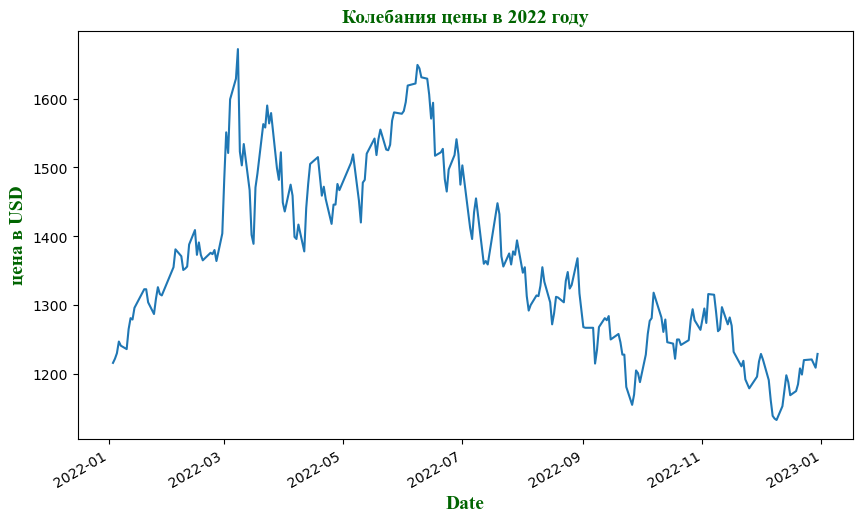

In [199]:
title_dict = {'fontsize':14, 
              'fontweight':'bold',
              'color':'DarkGreen',
              'family':'Times New Roman'}
rcParams['figure.figsize'] = 10,6
plt.title('Колебания цены в 2022 году', fontdict=title_dict)
plt.xlabel('Дата', fontdict=title_dict)
plt.ylabel('цена в USD', fontdict=title_dict)
total_plt_graf.plot()

In [200]:
total_cost_for_customers = oil_euro_cost_2022
for x in range(0,len(customers)):
    customer = customers[list(customers.keys())[x]]
    name_customer= list(customers.keys())[x]
    volume = customers[list(customers.keys())[x]]['volumes']
    if volume <= int(list(discounts.keys())[0]):
        sale = 1-(discounts[list(discounts.keys())[0]])
        #print(sale)
    elif volume > int(list(discounts.keys())[0]) and volume <= int(list(discounts.keys())[1]):
        sale = 1-(discounts[list(discounts.keys())[1]])
        #print(sale)
    elif volume >= int(list(discounts.keys())[2]):
        sale = 1-(discounts[list(discounts.keys())[2]])
    else: sale = 1
        #print(sale)
    if customers[list(customers.keys())[x]]['location'] == 'EU':
        region = EU_LOGISTIC_COST_EUR
    elif customers[list(customers.keys())[x]]['location'] == 'CN':
        region = CN_LOGISTIC_COST_USD
    else: region = 1
    total_cost_for_customers[name_customer] = total_cost_for_customers['cost'].apply(lambda x: 0.000001 * x * volume * region * sale)
    #
total_cost_for_customers

,Date,oil_p,euro_p,cost,Сonty,Triangle,Stone,Ant,Ivan
Date,,,,,,,,,
2022-01-03,2022-01-03,76.080002,1.137346,1215.738382,6.929709,4.693966,5.197282,2.527520,0.328249
2022-01-04,2022-01-04,76.989998,1.130224,1221.989765,6.965342,4.718102,5.224006,2.540517,0.329937
2022-01-05,2022-01-05,77.849998,1.128363,1229.844999,7.010116,4.748432,5.257587,2.556848,0.332058
2022-01-06,2022-01-06,79.459999,1.131350,1247.139864,7.108697,4.815207,5.331523,2.592804,0.336728
2022-01-07,2022-01-07,78.900002,1.129688,1240.875273,7.072989,4.791019,5.304742,2.579780,0.335036
...,...,...,...,...,...,...,...,...,...
2022-12-23,2022-12-23,79.559998,1.060333,1219.733181,6.952479,4.709390,5.214359,2.535825,0.329328
2022-12-27,2022-12-27,79.529999,1.064022,1220.908861,6.959181,4.713929,5.219385,2.538270,0.329645
2022-12-28,2022-12-28,78.959999,1.063717,1215.086651,6.925994,4.691450,5.194495,2.526165,0.328073


In [201]:
total_cost_for_customers_for_excel = total_cost_for_customers
total_cost_for_customers_for_excel.index = total_cost_for_customers_for_excel['Date']
total_cost_for_customers_for_excel = total_cost_for_customers_for_excel.resample('M').mean()
total_cost_for_customers_for_excel = total_cost_for_customers_for_excel.reset_index() 


In [202]:
xlfilepath = 'prices_for_customers.xlsx'
with pd.ExcelWriter(xlfilepath, engine='xlsxwriter') as writer:
    for x in range(0,len(customers)):
        customer = customers[list(customers.keys())[x]]
        name_customer= list(customers.keys())[x]
        volume = customers[list(customers.keys())[x]]['volumes']
        if volume <= int(list(discounts.keys())[0]):
            sale = 100*(discounts[list(discounts.keys())[0]])
        elif volume > int(list(discounts.keys())[0]) and volume <= int(list(discounts.keys())[1]):
            sale = 100*(discounts[list(discounts.keys())[1]])
        elif volume >= int(list(discounts.keys())[2]):
            sale = 100*(discounts[list(discounts.keys())[2]])
        else: sale = 0   
        if customers[list(customers.keys())[x]]['location'] == 'EU':
            region2 = EU_LOGISTIC_COST_EUR
        elif customers[list(customers.keys())[x]]['location'] == 'CN':
            region2 = CN_LOGISTIC_COST_USD
        else:
            region2 = 0
        customer_df = pd.DataFrame(total_cost_for_customers_for_excel, columns = ['Date', 'cost', name_customer])
        customer_df = customer_df.rename(columns = {name_customer : 'Total_cost'})
        customer_df.Date = customer_df.Date.dt.strftime('%B %Y')
        customer_df_graf = customer_df.set_index('Date')['Total_cost']
        title_dict = {'fontsize':14, 
                      'fontweight':'bold',
                      'color':'DarkRed',
                      'family':'Times New Roman'}
        rcParams['figure.figsize'] = 9,6
        plt.title('Цена за прошлый год', fontdict=title_dict)
        plt.xlabel('Дата', fontdict=title_dict)
        plt.ylabel('цена в миллионах $', fontdict=title_dict)
        customer_df_graf.plot()
        plt.grid()
        #plt.show()
        plt.savefig(f'{name_customer}_price.png')
        plt.close()
        
        
        max_row, max_col = customer_df.shape
        customer_df.to_excel(writer, sheet_name=name_customer, startrow=2, header=False, index=False)
        workbook = writer.book
        worksheet = writer.sheets[name_customer]
        cell_format = workbook.add_format({'bold': True, 'font_color': 'black', 'size':14})
        worksheet.write('A1', f'Покупатель:{name_customer} Объем: {volume} Цена доставки: {region2} $, скидка: {sale}%. Общая цена в миллионах долларов', cell_format)
        mean_cost_for_customer = round(customer_df['Total_cost'].mean(), 2)
        worksheet.write('A2', f'Средняя цена за прошлый год на заданный объем с учетом скидки и доставки:{mean_cost_for_customer} миллионов долларов', cell_format)
        column_settings = [{'header': column} for column in customer_df.columns]
        worksheet.add_table(2, 0, max_row, max_col - 1, {'columns': column_settings})
        worksheet.insert_image(max_row + 4, 1, f'{name_customer}_price.png')

# Задание 2

Клиенты согласились на ваше предложение. 
Вам нужно сделать написать скрипт, с помощью которого можно автоматом рассчитывать цены для всех клиентов одновременно. 
Важный момент: данные для расчета скрипт должен подтягивать сам.

In [203]:
#Данные о клиентах и объемах торгов лежат в файле customers.txt откуда автоматически выгружаются и могут быть редактированы. 
#Остальное считается автоматически.

# Задание 3

К вам пришел новый клиент из России. Который использует продукт А и готов регулярно закупать СК для того, чтобы не быть привязанным к одному поставщику. Клиент готов забирать СК с завода самостоятельно.
На основе тех данных, которые уже есть предложите цену новому клиенту в рублях. 



In [204]:
rub_price = pd.DataFrame(rub_price_full, columns = ['Close'])
rub_price = rub_price.reset_index()
rub_price_2022 = rub_price[rub_price['Date']>='2022-01-01']
rub_price_2022 = rub_price_2022[rub_price_2022['Date']<'2023-01-01']
rub_price_2022 = rub_price_2022.reset_index(drop=True)
rubberprice_2022 = pd.DataFrame(total_cost_for_customers, columns = ['Date' , 'Ivan'])
rubberprice_2022 = rubberprice_2022.reset_index(drop=True)

In [205]:
rubberprice_2022_ru = pd.merge(rubberprice_2022, rub_price_2022, on=('Date') , how='inner')
rubberprice_2022_ru_cost = rubberprice_2022_ru.assign(Ivan_ru = rubberprice_2022_ru['Ivan'] * rubberprice_2022_ru['Close'])
rubberprice_2022_ru_cost

,Date,Ivan,Close,Ivan_ru
0,2022-01-03,0.328249,74.986000,24.614107
1,2022-01-04,0.329937,74.371803,24.538027
2,2022-01-05,0.332058,75.263000,24.991693
3,2022-01-06,0.336728,76.661598,25.814088
4,2022-01-07,0.335036,76.353699,25.581263
...,...,...,...,...
247,2022-12-23,0.329328,68.214996,22.465106
248,2022-12-27,0.329645,68.330002,22.524670
249,2022-12-28,0.328073,69.964996,22.953654
250,2022-12-29,0.326476,72.714996,23.739695


In [206]:
ru_cost_mean = round(rubberprice_2022_ru_cost['Ivan_ru'].mean(),2)
print(f'Средняя цена для покупателя из России за прошлый год на запрашиваемый объем составила: {ru_cost_mean} миллионов рублей ')

Средняя цена для покупателя из России за прошлый год на запрашиваемый объем составила: 26.13 миллионов рублей 
